In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [15]:
df = hd.read_sample("777")
hd.inspect(df)

Time for read_data      : 3.23 seconds
(69,422, 32)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,savings,balance,income,entropy_tag
0,688261,2012-01-03,777,400.00,mdbremoved,NaN,transfers,transfers,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,364.220001,non merchant mbl,transfers,other account,other account,u,201201,0.0,-1542.99646,24319.220881,3.531665
1,688264,2012-01-03,777,10.27,9572 30dec 11 mcdonalds restaurant winwick road gb,mcdonalds,spend,services,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2015-03-19,True,364.220001,mcdonalds,dining and drinking,NaN,dining and drinking,u,201201,0.0,-1542.99646,24319.220881,3.531665


<AxesSubplot:>

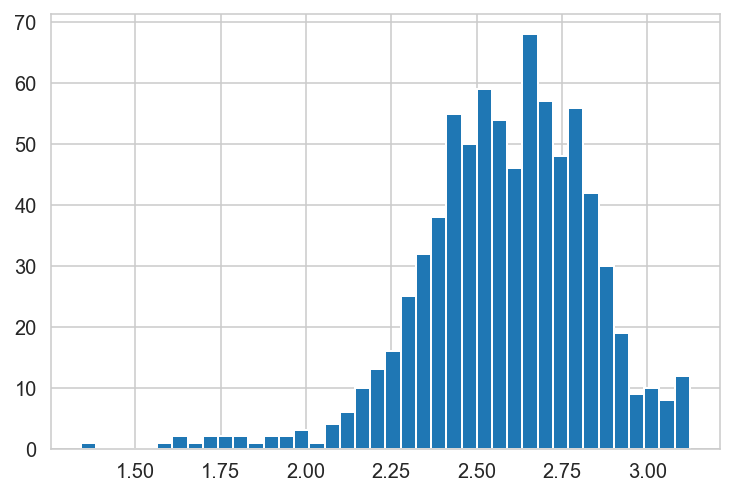

In [31]:
k = cr.entropy_spend_tag_counts(df)
k.groupby(["user_id", "ym"]).entropy_sptac.first().hist(bins=40)

In [41]:
cats = df.select_dtypes('category')
cats.apply(lambda x: x.str.lower()).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69422 entries, 0 to 69421
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   desc                    69422 non-null  object
 1   merchant                39467 non-null  object
 2   tag_group               55552 non-null  object
 3   tag                     55996 non-null  object
 4   user_postcode           69422 non-null  object
 5   user_salary_range       19994 non-null  object
 6   account_provider        69422 non-null  object
 7   account_type            69422 non-null  object
 8   merchant_business_line  49784 non-null  object
 9   tag_auto                55552 non-null  object
 10  tag_manual              2776 non-null   object
 11  tag_up                  53437 non-null  object
 12  updated_flag            69422 non-null  object
dtypes: object(13)
memory usage: 6.9+ MB
